---
title: Introduction to Multi-task Gaussian Processes
author: Marta Grzeskiewicz
date: 2020-02-17

---

A significant part of scientific literature focuses on fitting and predicting from an unknown function. When the function is complex, does not have a closed-form solution or is 'blackbox', a strategy is required to fit such a function with limited prior information. Bayesian optimisation is a class of machine learning-based optimisation methods focused on such a problem, which is characterised by the objective
<center>$\max_x f(x)$<center>

In these cases, although the true function $f$ is unknown, we can use existing prior knowledge about its properties, such as smoothness, which makes some objective functions more applicable than others in the specific problem. This method utilised Bayes’ theorem, $P(f|D) \propto P(D|f)P(f)$, where $f$ is the function in question and $D$ is the observed dataset. This theorem states that the posterior function is proportional to the likelihood multiplied by the prior. The likelihood is obtained by observing data and the prior is a pre-defined function, chosen by the researcher. This allows us to update the prior view of the distribution over the function values. 

We can also do this iteratively, whereby today’s posterior becomes tomorrow’s prior. This means that the posterior that has been calculated with one set of observations can be used as a prior for another dataset and updated again to get the updated posterior. If the cost to observing data is zero, we can do this infinitely many times. Often, the prior is chosen to be a Gaussian process (GP), which describes the potential values of $f$ at new points $x$. Intuitively, we can think of a Gaussian process as analogous to a function, but instead of returning a point-value for $f(x)$ for some $x$, it returns the mean and variance of a normal distribution over the possible values of $f$ at $x$.

### Single-task GPs

A GP is a generalisation of the Gaussian probability distribution, which governs the properties of functions. It is a non-parametric stochastic process, such that every sampled finite collection of these random variables has a multivariate normal distribution. Therefore, the distribution of a GP is the joint distribution of these random variables and it 
describes a distribution over the functions which generate these random variables.

<center> $m(x) = \mathbb{E} \left[ f(x) \right]$<center>

<center> $k(x, x') = \mathbb{E} \left[ \left(f(x) - m(x))(f(x') - m(x')\right) \right]$ <center>
   

These processes are defined entirely by a mean function $m(x)$ and a covariance function $k(x, x')$, defined above. The covariance matrix is then constructed by evaluating the covariance function, or kernel, at each pair of points, $(x_i, x_j)$. The kernel is chosen such that points which are close together in the input space have a large positive correlation, reflecting the belief that they should have more similar function values than points that are far apart. 

The GP is then given by $f(x) \sim GP(m(x), k(x, x'))$. We can simply consider the GP as a collection of random variables, where each random variable represents the value of the function $f(x)$ at location $x$. Alternatively, we can consider the above as the joint distributions over the collection of function evaluations $f(x_1), . . . , f(x_n)$. Let $X = [x_1,\dots,x_n]$ denote the evaluated points, $m(X) = \left[m(x_1),\dots, m(x_n)\right]^T$ denote the vector of means, and let

<center>$K(X,X) = \begin{bmatrix}k(x_1,x_1) & \dots & k(x_1,x_N) \\ \vdots & \ddots & \vdots \\ k(x_N,x_1) & \dots & k(x_N, x_N) \end{bmatrix}$

denote the covariance matrix across X. Then, the GP prior is given by 

<center>$f(x_1), \dots , f(x_N) \sim \mathcal{N}(m(X), K(X, X))$<center>
    
To implement this using GPy, we first generate some data and then define a kernel and a model.  

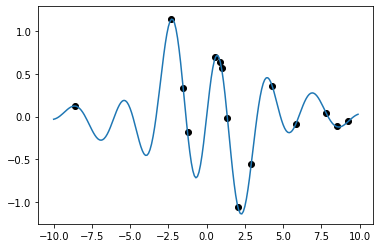

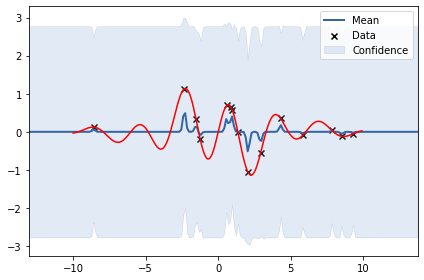

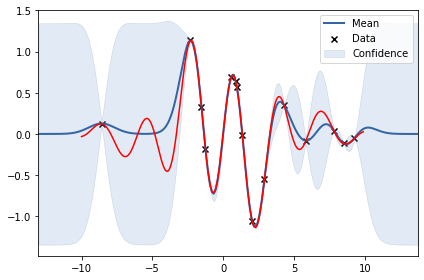

In [16]:
import numpy as np
import GPy 
import matplotlib.pyplot as plt
np.random.seed(0)

x = np.arange(-10, 10, 0.1)[..., np.newaxis]
def get_y(x):
    return (np.sin(2*x)-0.5*np.sin(3*x/4))/np.cosh(x/3)
y = get_y(x)

x_train = np.random.uniform(-10, 10, 15)[..., np.newaxis]
y_train = get_y(x_train) + np.random.normal(0, 0.01)

plt.plot(x, y)
plt.scatter(x_train, y_train, color = 'black')
plt.show()

d = 1
var = 1.
theta = 0.1

kernel = GPy.kern.RBF(d, var, theta)
m = GPy.models.GPRegression(x_train, y_train, kernel)
m.plot()
plt.plot(x, y, color = 'red',label = 'Ground truth')
plt.show()

m.optimize()
m.plot()
plt.plot(x, y, color = 'red',label = 'Ground truth')
plt.show()


#### Kernels

The covariance function specifies the covariance between any two points in the design space and is typically chosen so that the covariance decays with distance, where $r = |\textbf{x} - \textbf{x}'|$.  An example of such a kernel is the ARD-RBF

<center>$k(r) = \tau^2 \exp \left( \frac{1}{2} \sum_{j=1}^{m} \left( \frac{r_j}{l_j} \right)^2 \right) $<center>

The kernel induces smoothness in $f(x)$ since points that are nearby in space are given high covariance. The degree of smoothness depends on the kernel variance and lengthscales, $\tau^2$ and $l_j$ , which are inferred from data, typically by maximizing the marginal likelihood or with slice sampling. 

The ARD-RBF kernel imposes strong smoothness assumptions about the function. A more general class is the Matern, which is given by

<center> $k_{Matern}(r) = \frac{2^{1-v}}{\Gamma (v)}  \left(\frac{\sqrt{2vr}}{l} \right)^v K_v\left(\frac{\sqrt{2vr}}{l} \right)$<center>

with positive parameters $v$ and $l$, where $K_v$ is a modified Bessel function. Most typically
used are for $v = 3/2$ and $v = 5/2$. For $v = 1/2$, the process becomes very rough and for $v \geq 7/2$ in it is probably very hard from finitie noisy training samples to distringuish between finite values of $v \geq 7/2$. The choice of the kernel is therefore problem-dependent, as the desired smoothness of the function is determined by kernel choice.

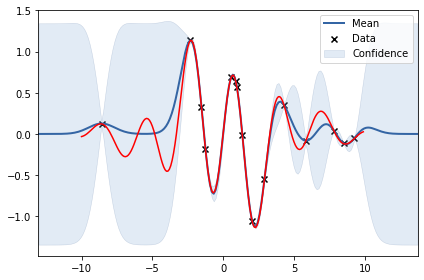

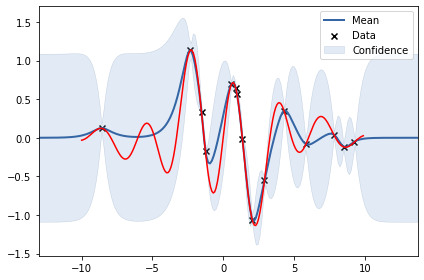

In [9]:
d = 1
var = 1.
theta = 0.4

kernel = GPy.kern.RBF(d, var, theta)
m = GPy.models.GPRegression(x_train, y_train, kernel)
m.optimize()
m.plot()
plt.plot(x, y, color = 'red',label = 'Ground truth')
plt.show()

kernel = GPy.kern.Matern32(d,var,theta)
m = GPy.models.GPRegression(x_train, y_train, kernel)
m.optimize()
m.plot()
plt.plot(x, y, color = 'red',label = 'Ground truth')
plt.show()

#### Prediction and sampling

We typically do not observe noise-free observations, but ones with an error, so our observations are given by $y_n = f(x_n) + \epsilon_n$, where $\epsilon_n \sim \mathcal{N}(0, \sigma_n^2I)$ is an independent and identically distributed Gaussian noise process. Let $\textbf{y} = [y_1,\dots, y_N]$ and $\boldsymbol{\sigma}^2$ = $[\sigma^2_1, \dots , \sigma^2_N]$. Since the noise processes are independent across observations, we are simply adding a diagonal matrix to the covariance of the function. It follows that the prior and marginal likelihood on the noisy observations is given by 

<center>$\textbf{y} \sim \mathcal{N}\left(m(X), K(X, X) + diag(\boldsymbol{\sigma}^2)\right)$<center>
    <center>$p(\textbf{y}|X)= \mathcal{N} (\boldsymbol{\mu}, K(X, X) + \sigma^2_{\epsilon}\textbf{I})$<center>

with mean vector $\boldsymbol{\mu}_i = \mu(x_i)$ and covariance matrix $K(X, X)$ determined from the mean function and covariance kernel of the Gaussian process. Now, we can update the prior to obtain the posterior distribution over the point we have not yet observed, $\textbf{x}_*$, which is given by 
<center>$f(\textbf{x}_*)|\textbf{x}_*, X, \textbf{y} \sim \mathcal{N} (\mu(\textbf{x}_*, X, \textbf{y}), \sigma^2(\textbf{x}_*, X))$<center>

where, with $K(\textbf{x}_*, X)$ as the $1 \times n$ vector of covariances between $\textbf{x}_*$ and each point in $X$,




<center>$\mu(\textbf{x}_*, X, \textbf{y}) = m(\textbf{x}_*) + K(\textbf{x}_*, X)[K(X, X) + diag(\boldsymbol{\sigma}^2)]^{-1}(\textbf{y} - m(X)) $<center>
<center>$\sigma(\textbf{x}_*, X) = K(\textbf{x}_*, \textbf{x}_*) - K(\textbf{x}_*, X)[K(X, X) + diag(\boldsymbol{\sigma}^2)]^{-1}K(X, \textbf{x}_*) $<center>

In the second of the above two equations, we see that the covariance does not depend on the observed targets ($\textbf{y}$), only the inputs $(X, \textbf{x}_*)$. The covariance is the difference between two terms; the first is the prior covariance, from which we subtract a positive term which represents the information the observations give us about the function.

Beacause the prediction requires a calculation of an inversion of a matrix, the computational complexity is $O(n^3)$ (if you're not familiar with the Big-Oh notation, check out [this video](https://www.youtube.com/watch?v=myYKuRcuybw)). As $n$ grows large, the time required to compute this grows polynomially, which is considered to be costly. There are sparse GPs and other approximations that get around this issue using variational inference (but no details are included here). 

### Multi-task GPs

Now that we have seen how to apply the Gaussian process methods on single-task problems, we can extend it to consider when we want to train two or more tasks simultaneously. The point is that we have functions we want to fit, optimize and predict from that are related, so we can use learn the other functions to be a better fit. Formally, the multi-task GP (MTGP) extends the GP from a single function $f$ to a collection of functions $f_1, ..., f_D$, where each function is a response surface for a task. The number of tasks, therefore, determines the number of functions in the collection. 

There are two general approaches to multi-task modelling: the hierarchical approach and the covariance approach. Both methods model the covariance across tasks in addition to covariance across the design space, which gives the following form of a kernel

<center>$k\left((d, x),(d', x')\right) = \text{Cov}\left[f_d(x), f_{d'}(x')\right]$<center>

The hirerarchical approach assumes independence across tasks, such that there exists a hyperprior, while the covariance approach considers covariances across tasks. 

![title](mtgps.jpg)

#### Hierarchical approach
Let $T$ denote the number of tasks in a maximisation problem. The hierarchical Gaussian process approach assumes a priori that the parameters of the T functions are all sampled from an unknown Gaussian distribution. Then, an iterative Gibbs sampling based approach is used to simultaneously estimate both the individual functions and the parameters of the parameter’s Gaussian distribution by integrating over the joint distribution. In this model, relatedness between the tasks is captured by this Gaussian distribution of parameters: the smaller the variance of the Gaussian the more related the tasks are. This hierarchy is depicted by the left panel in figure 2. At the lowest level are the outputs, $y_i = f_i(x) + \epsilon_i$, where $\epsilon_i \sim \mathcal{N}(0, \sigma^2)$ and $i = 1,\dots,T$ represents the task number, here $T = 3$. At the middle level we have the functions $f_i$, which are goverened by the parameters, $w$. For example, the parameters could be the parameters in a linear model, or the weights in a neural network model. At the top level are hyperparameters $\theta$ which control the distribution of the parameters at the middle level. The prior on $\theta$ may be generic, for example, isotropic Gaussian or more structured. This method does not need to involve the task covariance computation and therefore the complexity is lower than the second multi-task approach. Some authors argue that the lack of a characteristic length-scale is appealing. This may sometimes be the case, but if we believe there is an appropriate length-scale (or set of length-scales) for a given problem but this is unknown in advance, we would argue that a hierarchical Bayesian formulation of the problem would be more appropriate.

#### Covariance approach

Alternative to the hierarchical approach, the covariance approach constructs a covariance matrix across all samples and task pairs. The general idea is that unlike the hierarchical approach which explicitly considers the hyperparameters, $\theta$, the covariance approach integrates out the hyperparameters and we are left with a kernel that considers the correlation between the different tasks. There are many kernels that can be chosen in this method and we focus on the intrinsic coregionalisation model which assumes separability between the input space kernel and the task covariance, where the input space kernel is shared across all tasks. This, however, is a strong assumption that can be justified by the problem being solved; for example, when there is one task based on real-life experiments and another using a simulator.

The general form for a separable kernel is $K = K_f ⊗ K_x$, where $⊗$ is the Kronecker product, $K_f$ is the task covariance matrix and Kx is the spatial covariance matrix, typically taken to be either the RBF or Matern kernels. The parameters of $K_f$ are typically optimised along with the other parameters in minimising the negative log marginal likelihood or infered by slice sampling.

The intrinsic coregionalisation model (ICM) has been widely used in the geo-statisticsliterature as the prior model for the general function $f$, which is a specific form of cokriging. This type of prior essentially assumes that each of the task latent functions is a linear combination of a further set of latent functions and the coefficients of the latent functions determine the weighting of each task. This model considers only one Kronecker product, whereas a more general version which considers many Kronecker products is called the linear model of coregionalisation, where each output is modelled as the convolution integral between a smoothing kernel and a latent random function common to all outputs. Therefore, the ICM is much more restrictive than the LMC since it assumes that each task covariance contributes equally to the construction of the kernels for the outputs. While these models seem to be restrictive in their linear form, they have proven to be effective. Although these cross-covariance-based methods can utilize prior information of task similarities, they have been limited in applications by the computation burden.

The covariance approach formulates a covariance matrix between tasks, which means that we can determine the extent of the relationship between any two tasks. We use a specific form of this approach called the Intrinsic Coregionalisation Model (ICM). This method assumes seperability of spatial and task kernels such that they can be optimised in parallel. Formally, we can write the covariance kernel of a Gaussian process as $K(X, X) = B ⊗ k(x, x')$ where $⊗$ is the Kronecker product, $B$ is a positive semi-definite task covariance matrix with element $B_{d,d'}$ representing the covariance between tasks $d$ and $d'$, and $k(x, x')$ is the spatial kernel function, such as the RBF. The Kronecker product essentially weights the spatial kernel elements by the covariance between the tasks, such that if B is shape $d \times d$ and $k(x, x')$, then $K(X, X)$ is shape $d_n \times d_n$. It then follows that the covariance between two task functions, $d$ and $d'$, is given by $Cov[f_d(x), f_{d'}(x')] = B_{d,d'}k(x, x')$. 

We are then able to directly substitute the above into the definition of the GP priorand subsequently the predictive distribution, like in the single-task case. The MTGP maintains all the desirable properties of the GP for BO. There are two assumptions made. Firstly, there is separability such that the task covariance can be separated from the spatial covariance and the two are independent. This results in the multiplicity of the covariance matrix and the kernel. Secondly, it has been assumed that all tasks share the same spatial kernel, which is denoted by $k(x, x')$. This assumption is useful to make since if there is a task with more data than another, we can rely on the first task to estimate the kernel parameters that are shared across all tasks. An alternative way to view this method is that the ICM kernel implicitly models each task function as being a linear combination of independent latent functions. Consider the case where we are modelling to related functions. The model can then be written as

<center>$f_1(x) = a_{11}u_1(x) + a_{12}u_2(x)$<center>
<center>$f_2(x) = a_{21}u_1(x) + a_{22}u_2(x)$<center>

where $u_1(x)$ and $u_2(x)$ have single-task GP priors with the same covariance function $k(x, x')$. The weights are related to the cross-task covariance of 21 as $B_{12} = a_{11}a_{21} + a_{12}a_{22}$. High cross-task covariance thus corresponds to the two task functions concentrating their weight on the same latent function. In the extreme case, if $a_{12} = a_{21} = 0$, the ICM kernel corresponds exactly to modelling the two tasks with independent GPs that have the same covariance function, $k(x, x')$.

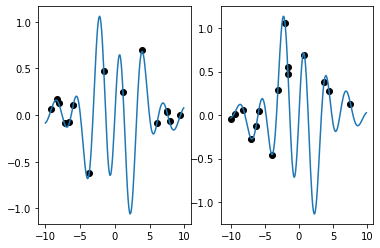

In [3]:
a = np.arange(-10, 10, 0.1)[..., np.newaxis]
def get_b(x):
    return (np.sin(2*x)-0.5*np.sin(x))/np.cosh(x/3)
b = get_b(a)

a_train = np.random.uniform(-10, 10, 15)[..., np.newaxis]
b_train = get_b(a_train) + np.random.normal(0, 0.01)

fig, (ax1, ax2) = plt.subplots(1,2)
ax1.plot(a, b)
ax1.scatter(a_train, b_train, color = 'black')
ax2.plot(x,y)
ax2.scatter(x_train,y_train,color='black')
plt.show()

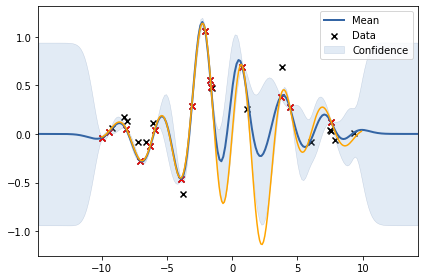

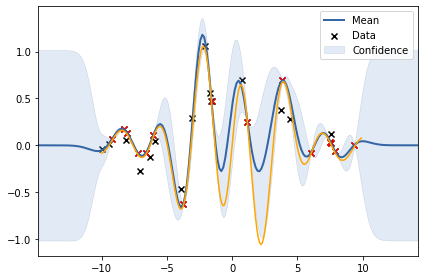

In [4]:
d = 1
var = 1.
theta = 0.2
kernel = GPy.kern.RBF(d, var, theta)
icm = GPy.util.multioutput.ICM(d,num_outputs=2,kernel=kernel)
m = GPy.models.GPCoregionalizedRegression([x_train,a_train],[y_train,b_train],kernel=icm)
m['.*rbf.variance'].constrain_fixed(1.)
m.optimize()


m.plot(fixed_inputs=[(1,0)])
plt.scatter(x_train,y_train, color='red', marker='x')
plt.plot(x,y,color='orange')
plt.show()

m.plot(fixed_inputs=[(1,1)])
plt.scatter(a_train,b_train, color='red', marker='x')
plt.plot(a,b,color='orange')
plt.show()

